## 6 Plume Analysis -- Temporal Variation

In [16]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.plume_utils.viz import show_images, label_violinplot
from plume_learn.plume_utils.manage_plume import remove_all_0_plume, load_json
from plume_learn.plume_analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from sro_sto_plume.modify_df import modify_df
from sro_sto_plume.packed_plot_functions import plot_temporal_violins, plot_temporal_heatmaps, plot_combined_temporal_variation
from matplotlib import colormaps
colors = colormaps.get_cmap('tab10').colors[:6]

from m3util.viz.printing import printer
printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_737306/1992214934.py:22: DeprecationWarning: The 'printer' class/function has been renamed to 'Printer'. Please update your code.
  printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)


### 1. Load Plume data

#### 1.1 load experiment conditions

In [17]:
sample_names = ['G1', 'G2', 'G3', 'G4', 'G5', 'C-G6']
sample_ids = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']
plume_recording_root = '../data/Plumes/plume_recordings/'
output_root = '../data/Plumes/plume_metrics/'

#### 1.2 load metrics for every plume frame

In [18]:
df_frame_metrics = []
for id, growth_name in zip(sample_ids, sample_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

/tmp/ipykernel_737306/3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_737306/3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_737306/3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_737306/3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_737306/3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Sample Name,Sample ID
0,0,0.0,0.000000,0.000000,0.0,200,G1,YG065
1,0,0.5,0.000000,0.000000,0.0,200,G1,YG065
2,0,1.0,0.008715,17429.394813,2074.0,200,G1,YG065
3,0,1.5,0.014784,12138.328530,3144.0,200,G1,YG065
4,0,2.0,0.021476,13383.285303,9039.0,200,G1,YG065
...,...,...,...,...,...,...,...,...
232827,287,61.5,0.032680,0.000000,0.0,200,G5,YG069
232828,287,62.0,0.032680,0.000000,0.0,200,G5,YG069
232829,287,62.5,0.032680,0.000000,0.0,200,G5,YG069
232830,287,63.0,0.032680,0.000000,0.0,200,G5,YG069


#### 1.3 calculate max area and incident velocity

In [19]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.029) & (df_frame_metrics['Distance (m)'] <= 0.030)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

,Sample Name,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
287,G2,180,3.0,17451.0,5291.066282
138,G1,306,3.0,18241.0,6224.783862
284,G2,174,3.0,14282.0,3112.391931
332,G2,263,3.0,14584.0,3734.870317
426,G3,42,3.0,15161.0,4979.827089


In [20]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.028) & (df_frame_metrics['Distance (m)'] <= 0.029)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

# df_sample
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0.5) & (df_frame_metrics['Time (µs)'] < 7)] 
df_sample = df_sample[df_sample['Sample Name'].isin(sample_names)]
df_sample = df_sample.dropna()  # Remove all rows with NaN values

### 2. Introduction to Plume Dynamics Analysis

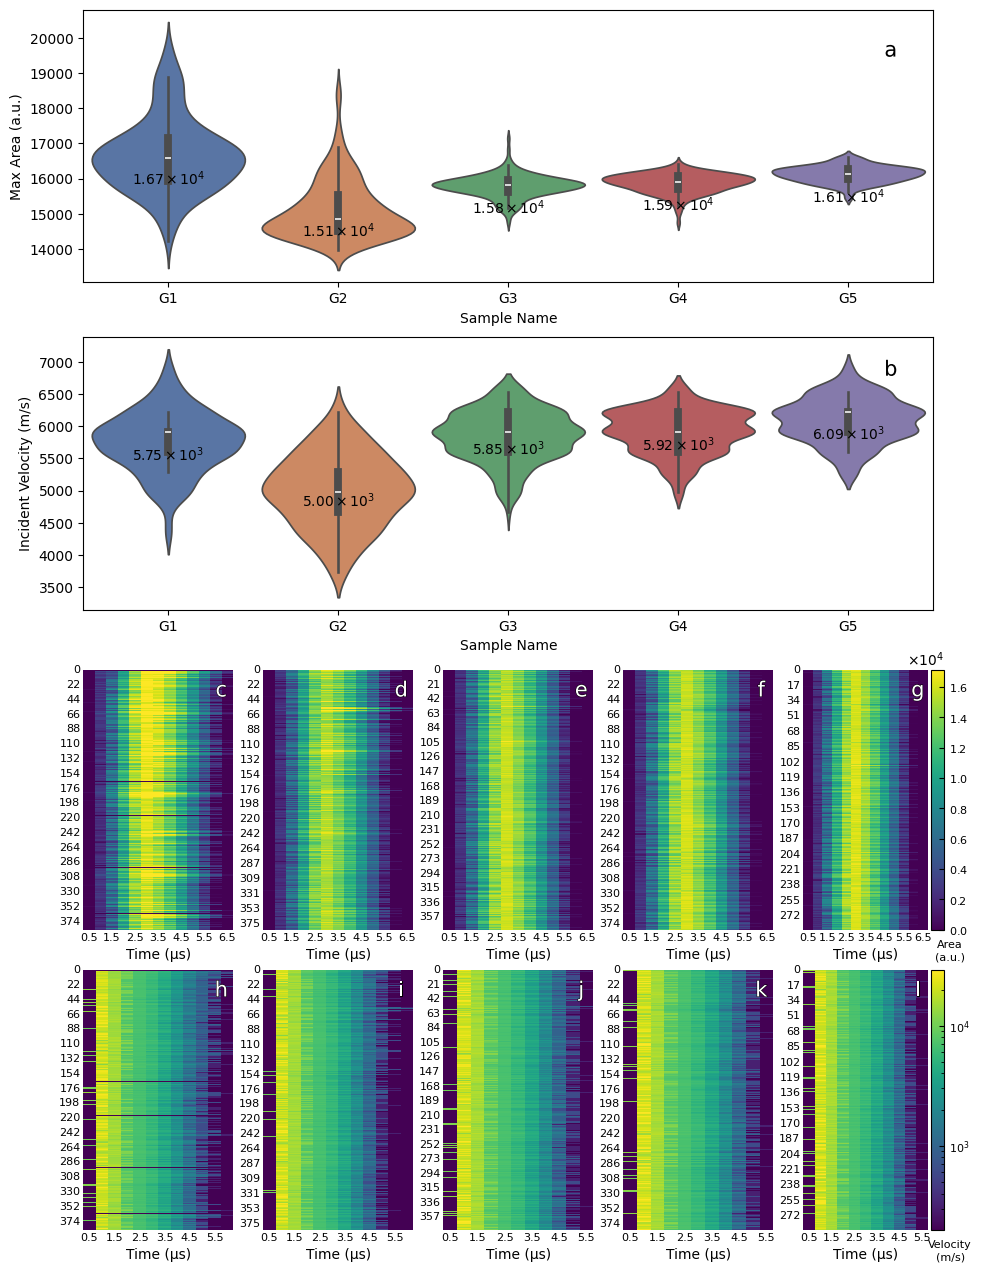

In [33]:
fig, axes_dict = plot_combined_temporal_variation(df_sample, sample_names, df_plume_metrics, label=True)

### 2.1 Violin Plot of Plume Max Area and Incident Velocity Statics

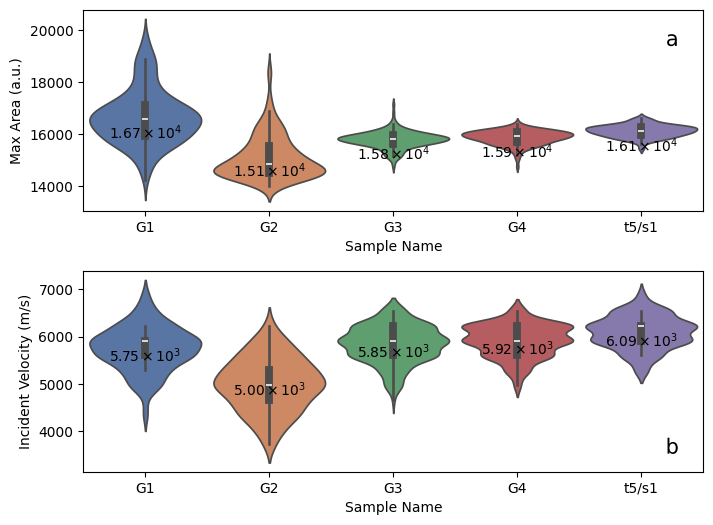

In [12]:
fig, axes = plot_temporal_violins(df_plume_metrics)
# printing.savefig(fig, '5-Plume_metrics_violinplot')
plt.show()

In [13]:
# fig, axes = plot_temporal_violins(df_plume_metrics, label=False)
# printing.savefig(fig, '5-Plume_metrics_violinplot-no_marks')
# plt.show()

### 2.2 Heatmaps

/mnt/scratch/home/yichen/anaconda3/envs/plume/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/mnt/scratch/home/yichen/anaconda3/envs/plume/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


ValueError: zero-size array to reduction operation fmin which has no identity

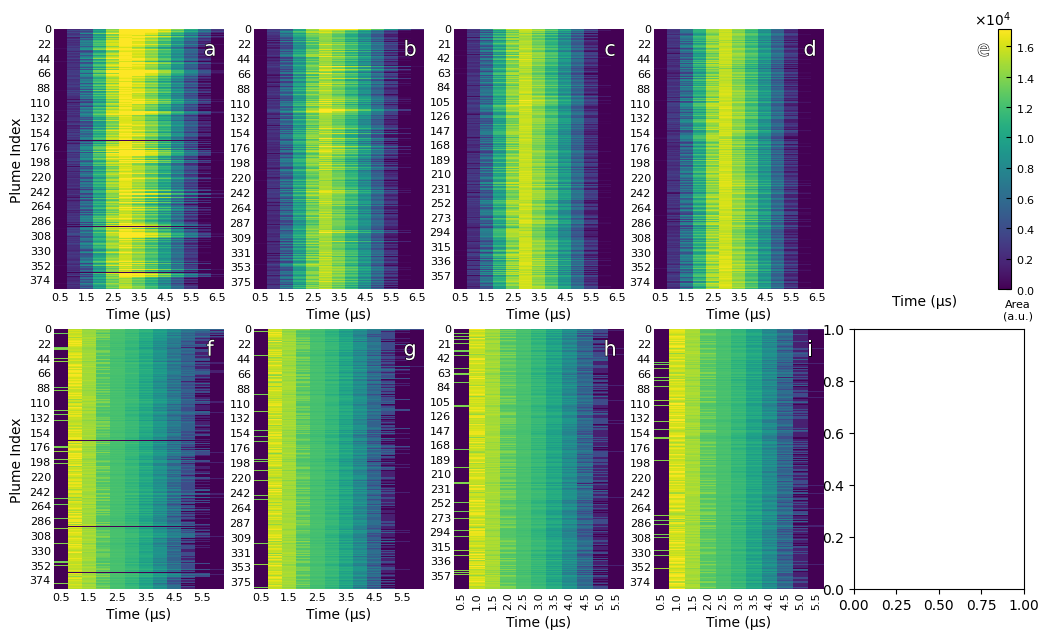

In [14]:
fig, axes_dict = plot_temporal_heatmaps(df_sample, sample_names)
# printing.savefig(fig, 'S8-Plume_metrics_temporal_heatmaps')
plt.show()

In [15]:
# fig, axes_dict = plot_temporal_heatmaps(df_sample, sample_names, label=False)
# printing.savefig(fig, 'S8-Plume_metrics_temporal_heatmaps-no_marks')
# plt.show()

In [15]:
sample_names

['t1', 't2', 't3', 't4', 't5']

In [ ]:
sample_names
fig, axes_dict = plot_temporal_heatmaps(df_sample, sample_names, custom_palette)
# plt.savefig('../figures/6-Spatial_inhomogeneity_area.svg', dpi=600, bbox_inches='tight', transparent=True)
printing.savefig(fig, '6-Spatial_inhomogeneity_area')
plt.show()